In [82]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
from urllib import urlretrieve
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.pylab.style.use("seaborn-muted")

In [11]:
def download_dataset(URL, dataset_name, force=False):
    path = "dataset/{}".format(dataset_name)
    if force or not os.path.exists(path):
        urlretrieve(URL, path)
    return path
dataset_location = download_dataset(
    URL="https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD", 
    dataset_name="FremontBridge.csv")

In [27]:
df = pd.read_csv(dataset_location, index_col="Date")
# get some stats about data
df.describe()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
count,41560.000000,41560.000000
mean,55.221824,53.991145
std,74.005863,77.915483
min,0.000000,0.000000
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,854.000000,717.000000


In [28]:
# check for null values
df.isnull().sum()

Fremont Bridge West Sidewalk    8
Fremont Bridge East Sidewalk    8
dtype: int64

In [29]:
df.columns = ["West", "East"]
df.index = pd.to_datetime(df.index, format="%m/%d/%Y %I:%M:%S %p")
df.head()

,West,East
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [51]:
df["Total"] = df["East"] + df["West"]

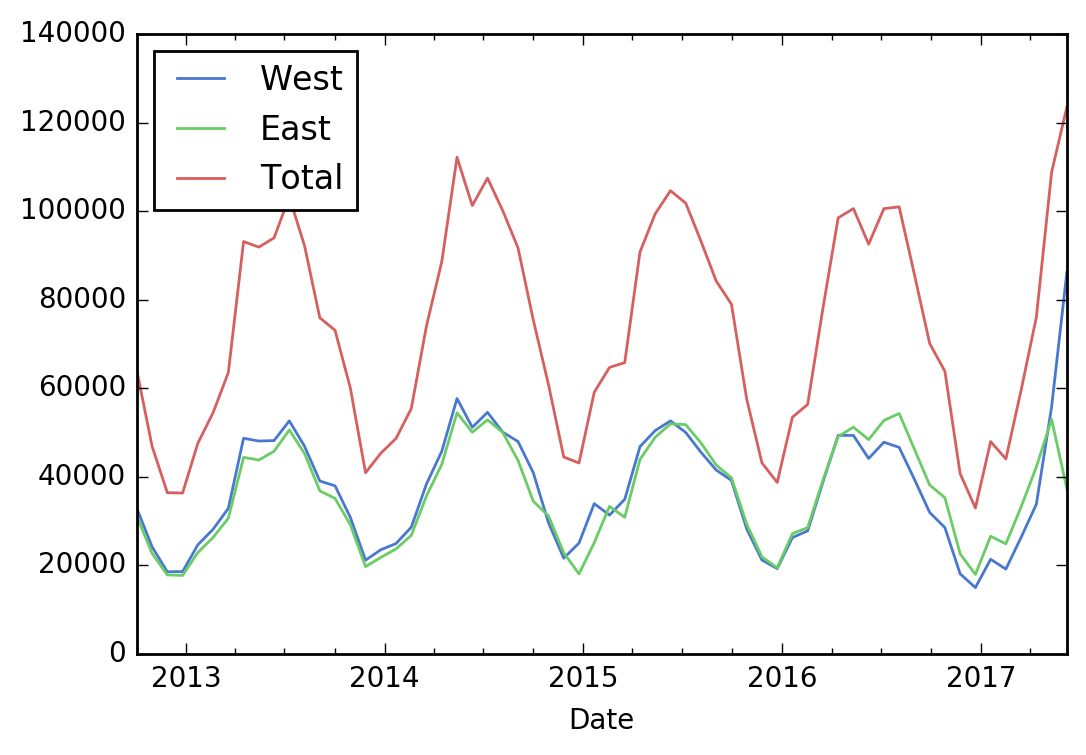

In [83]:
df.resample("28D").sum().plot();

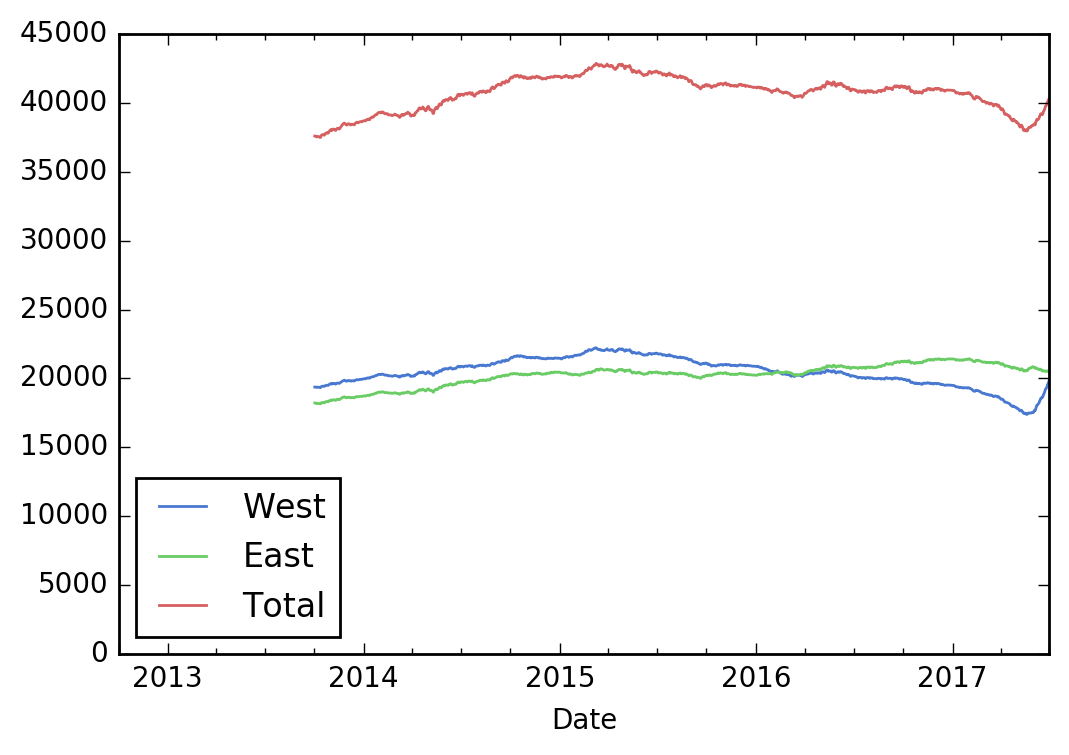

In [84]:
df.resample("D").rolling(365).sum().plot()
mpl.pylab.ylim([0, None]);

In [88]:
pivoted = df.pivot_table(["East", "West"], index=df.index.date, columns=df.index.hour, fill_value=0)
pivoted.head().T

2012-10-03  2012-10-04  2012-10-05  2012-10-06  2012-10-07
East 0            9          11           7           7           5
     1            6           0           4           5           5
     2            1           6           3           2           1
     3            3           3           2           2           2
     4            1           1           2           1           2
     5           10          11           7           2           3
     6           50          51          37          15           8
     7           95          89         101          16          12
     8          146         134         119          47          26
     9          104          94          81          55          36
     10          46          53          48          47          41
     11          32          55          61          48          71
     12          41          50          46          73          91
     13          48          71          50          82          99
     14          51          56          62         114         115
     15          92          74          84          96         109
     16         182         161         190          76          93
     17         391         353         290          73          73
     18         258         241         209          55          45
     19          69         107          73          38          23
     20          51          56          41          18          36
     21          38          39          31          15          35
     22          25          21          26          20           9
     23          12          30          16          19          11
West 0            4           7           4           8           6
     1            4           3           4          10          12
     2            1           3           4           7           2
     3            2           0           2           1           4
     4            6           7           7           4           1
     5           21          15          18           3           6
     6          105          91          68          12           9
     7          257         230         218          17          14
     8          291         284         251          58          43
     9          172         147         131          59          67
     10          72          67          71          68          67
     11          10          53          43          76          94
     12          35          54          55          91         100
     13          42          55          62          95         129
     14          77          63          63          89         126
     15          72          73          80         115         122
     16         133         114         120         107         132
     17         192         154         144         107         118
     18         122         137         107          41          68
     19          59          57          42          40          26
     20          29          27          27          25          19
     21          25          31          11          18          12
     22          24          25          10          14           9
     23           5          11          16          15           5

In [90]:
pivoted.values.shape

(1732, 48)

In [122]:
from sklearn.decomposition import PCA
X = pivoted.values
Xpca = PCA(0.90).fit_transform(X)
Xpca.shape

(1732, 3)

In [123]:
total_trips = X.sum(1)

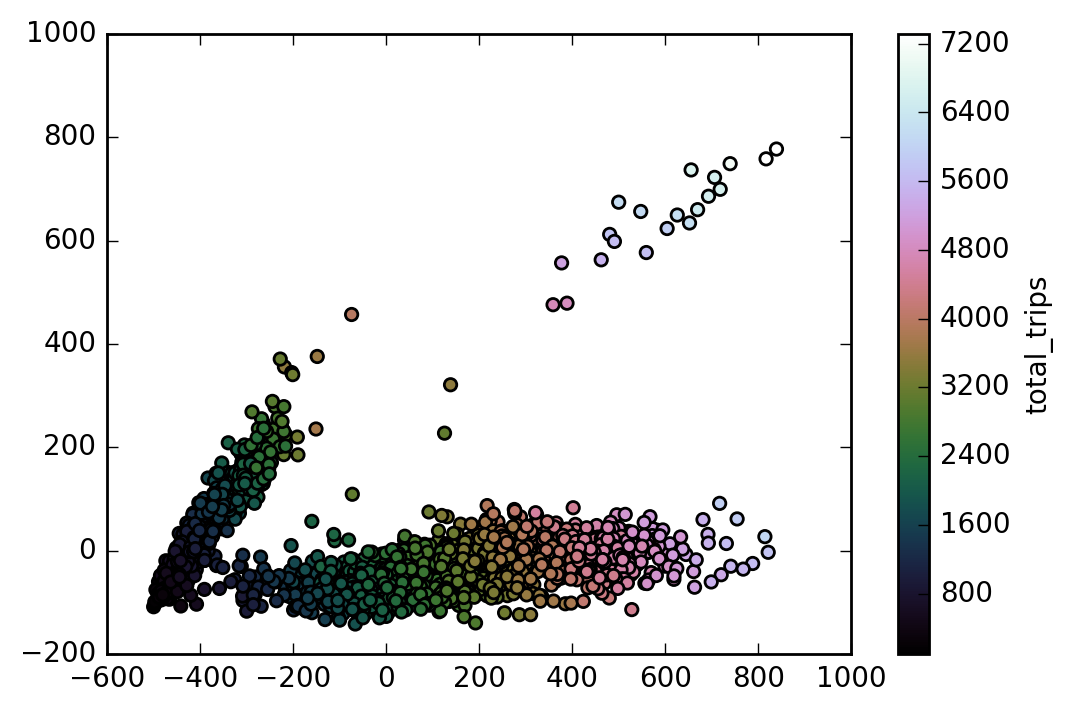

In [124]:
mpl.pyplot.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap="cubehelix")
mpl.pyplot.colorbar(label="total_trips");

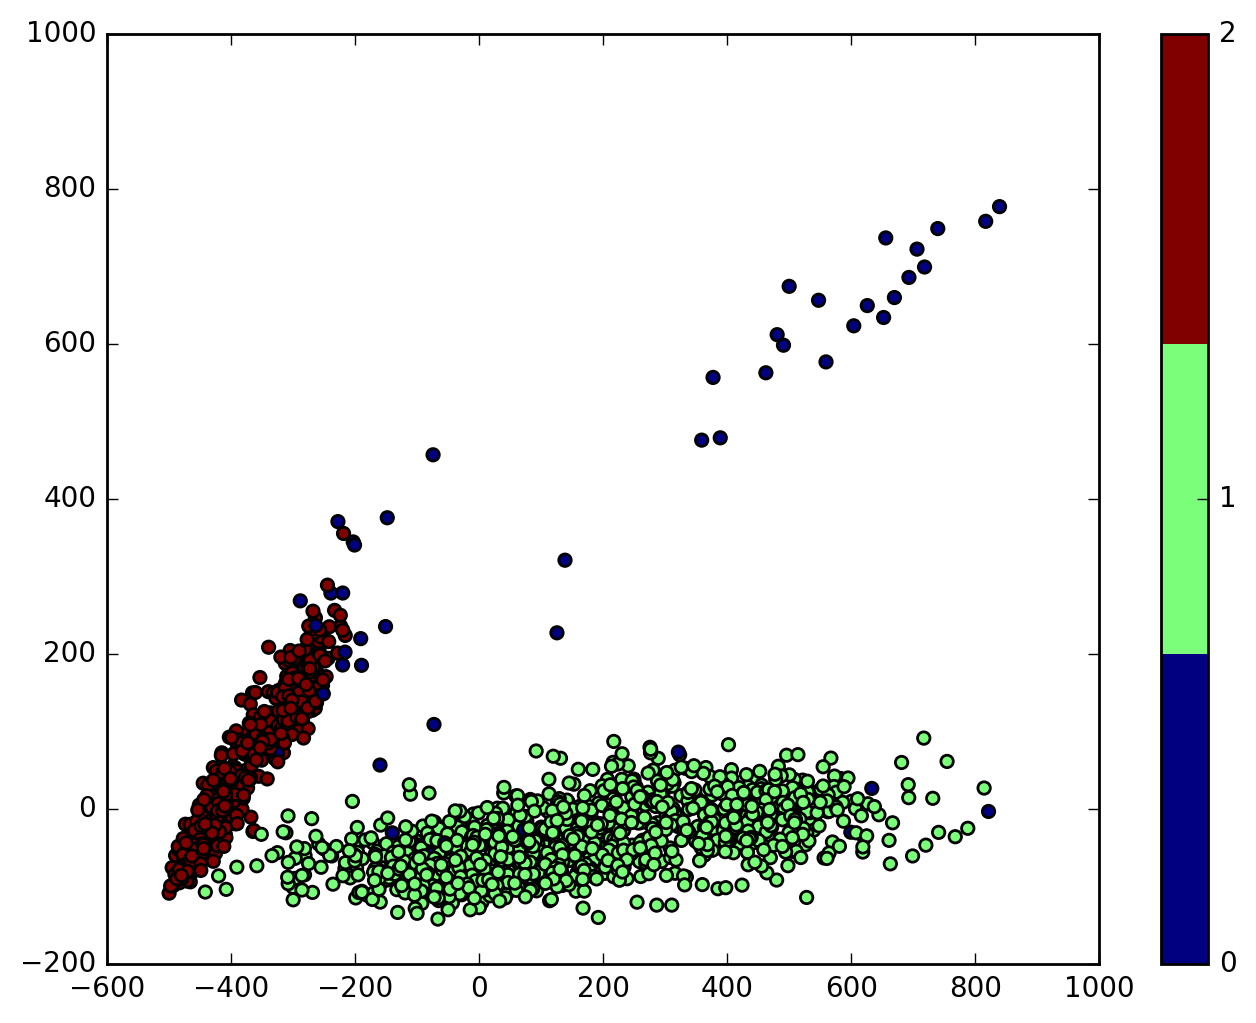

In [152]:
from sklearn.mixture import GMM
gmm = GMM(3, covariance_type="full", random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
mpl.pyplot.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, 
                   cmap=mpl.pyplot.cm.get_cmap('jet', len(np.unique(cluster_label))))
mpl.pyplot.colorbar(ticks=np.unique(cluster_label));

In [127]:
pivoted['Cluster'] = cluster_label
df = df.join(pivoted['Cluster'], on=df.index.date)
df.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,1
2012-10-03 01:00:00,4.0,6.0,10.0,1
2012-10-03 02:00:00,1.0,1.0,2.0,1
2012-10-03 03:00:00,2.0,3.0,5.0,1
2012-10-03 04:00:00,6.0,1.0,7.0,1


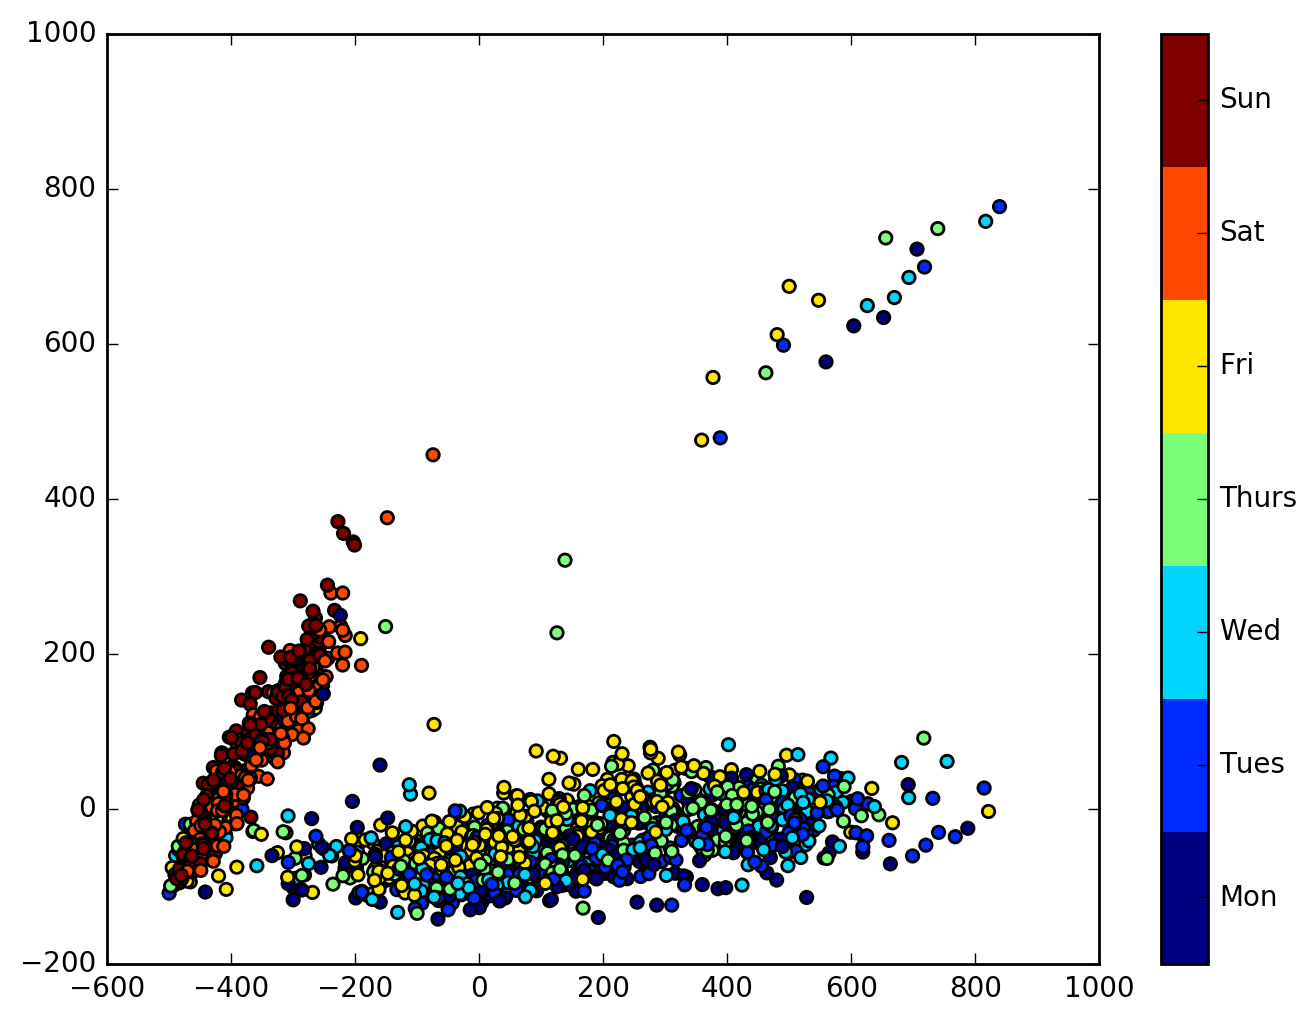

In [146]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
mpl.pyplot.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=mpl.pyplot.cm.get_cmap('jet', 7))
cb = mpl.pyplot.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
mpl.pyplot.clim(-0.5, 6.5);